In [ ]:
import torch
import torch.nn as nn
from torch.autograd import detect_anomaly
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/lfw.zip', 'r') as zip_ref:
    zip_ref.extractall('')
path = 'lfw'

In [ ]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}.")


Using cuda.


torch.Size([250, 250, 3])


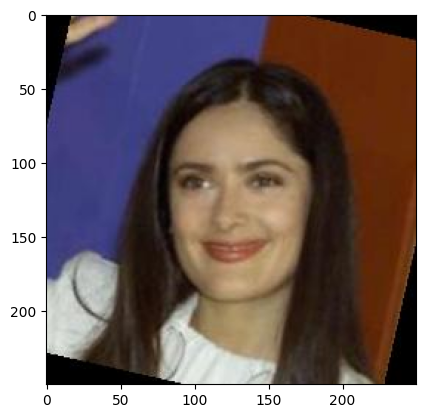

In [ ]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

In [ ]:
1. Applications:

AutoEncoders (AEs):
AutoEncoders are primarily used for dimensionality reduction and feature learning. They find applications in tasks such as data compression, denoising, and feature extraction. In image processing, for instance, AutoEncoders can be employed for reconstructing images, capturing essential features in the encoded representation.

Variational Autoencoders (VAEs):
Variational Autoencoders, on the other hand, introduce a probabilistic element to the latent space, making them particularly well-suited for generating new data points. VAEs are widely used in generative tasks, including image synthesis, style transfer, and other applications where generating diverse samples from the learned distribution is crucial.

2. Architecture:

AutoEncoders (AEs):
AutoEncoders consist of an encoder and a decoder. The encoder compresses the input data into a latent representation, and the decoder reconstructs the input from this representation. AEs lack a probabilistic framework in the latent space, leading to a deterministic mapping of inputs to latent representations.

Variational Autoencoders (VAEs):
VAEs also have an encoder and decoder, but they introduce a probabilistic layer in the latent space. The encoder maps input data to probability distributions in the latent space, capturing the uncertainty inherent in the encoding process. This probabilistic approach enables the generation of new data points by sampling from the learned distributions in the latent space.

3. Loss Function:

AutoEncoders (AEs):
The loss function for AutoEncoders typically involves measuring the difference between the input and the reconstructed output. Mean Squared Error (MSE) is commonly used for this purpose. The optimization goal is to minimize the reconstruction error, leading to a deterministic mapping in the latent space.

Variational Autoencoders (VAEs):
In VAEs, the loss function is more complex. It comprises two components: the reconstruction loss and the KL divergence. The reconstruction loss measures how well the generated output matches the input, similar to AEs. The KL divergence penalizes the divergence between the learned probability distributions in the latent space and a predefined distribution (usually a unit Gaussian). The objective is to balance the trade-off between accurate reconstruction and a well-structured latent space.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_channels, latent_dims):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)

        self.fc_mu = nn.Linear(64 * 32 * 32, latent_dims)
        self.fc_logvar = nn.Linear(64 * 32 * 32, latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        return self.fc_mu(x), self.fc_logvar(x)

class Decoder(nn.Module):
    def __init__(self, latent_dims, output_channels, output_size):
        super(Decoder, self).__init__()

        self.decoder_input = nn.Linear(latent_dims, 64 * 32 * 32)

        self.conv_trans1 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.conv_trans2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=1)
        self.conv_trans3 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1)
        self.conv_trans4 = nn.ConvTranspose2d(16, output_channels, kernel_size=4, stride=1, padding=0)

    def forward(self, z):
        x = F.relu(self.decoder_input(z))
        x = x.view(x.size(0), 64, 32, 32)
        x = F.relu(self.conv_trans1(x))
        x = F.relu(self.conv_trans2(x))
        x = F.relu(self.conv_trans3(x))
        x = torch.sigmoid(self.conv_trans4(x))
        return x

class VAE(nn.Module):
    def __init__(self, input_channels=3, input_size=250, latent_dims=20):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_channels, latent_dims)
        self.decoder = Decoder(latent_dims, input_channels, input_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [ ]:
# Instantiate the VAE model
vae = VAE().to(device)

# Load one batch of images
images, _ = next(iter(dataloader))
images = images.to(device)

# Forward pass through the model
decoded, mu, logvar = vae(images)

# Print the shape of the output of the encoder
print("Shape of mu (output of the encoder):", mu.shape)

# Explain how to generate new samples in the latent space
# Explanation:
# The encoder produces two vectors, mu and logvar, which represent the mean and log variance of the latent space.
# To generate new samples in the latent space, we use the reparameterization trick.
# We sample random values from a normal distribution, multiply them by the standard deviation (exp(logvar/2)),
# and add the mean. This results in a sampled point (z) in the latent space.
std = torch.exp(0.5 * logvar)
eps = torch.randn_like(std)
z = mu + eps * std

# Print the shape of the sampled latent space
print("Shape of latent space samples (z):", z.shape)

# Use the decoder to create new images
new_images = vae.decoder(z)

# Print the shape of the output of the decoder
print("Shape of the output of the decoder (new images):", new_images.shape)

# Verify that the forward pass is working correctly
# Explanation:
# The VAE should be able to reconstruct the input images and generate new images.
# By comparing the shapes of the decoded images and the original images, we can ensure that the forward pass is functioning as expected.
print("Shape of the original images:", images.shape)


Shape of mu: torch.Size([32, 20])
Shape of logvar: torch.Size([32, 20])
Shape of latent space samples (z): torch.Size([32, 20])
Shape of decoded images: torch.Size([32, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [ ]:
total_params = sum(p.numel() for p in vae.parameters())
print("Total number of parameters in the model:", total_params)

optim = torch.optim.Adam(vae.parameters(), lr=1e-3)

The model has 4,071,867 trainable parameters.


Explanation:

Counting Parameters:

The count_parameters function calculates the total number of trainable parameters in the model. It iterates through all model parameters and counts the number of elements (weights and biases) that require gradients. This information is useful for understanding the model's complexity and the memory it will consume during training.
Explanation of the Loss Function:

The loss function used is a combination of Binary Cross Entropy (BCE) and Kullback-Leibler Divergence (KLD). This combination is commonly known as the Variational Autoencoder (VAE) loss.
Binary Cross Entropy (BCE):
BCE measures the reconstruction error between the generated images (recon_x) and the original input images (x). It is a pixel-wise loss, comparing the similarity between the generated and original images.
Kullback-Leibler Divergence (KLD):
KLD regularizes the latent space by penalizing deviations from a standard normal distribution. It encourages the model to have a latent space that is close to a normal distribution, aiding in the generation of diverse and meaningful samples.
The total loss is the sum of BCE and KLD, and the goal is to minimize this combined loss during training.
Optimizer for Training:

The Adam optimizer is used for training the model. It is an adaptive learning rate optimization algorithm that combines the advantages of both momentum and RMSprop. The learning rate is set to 1e-3, but this value can be adjusted based on experimentation and model performance.

In summary, the VAE loss function consists of a reconstruction term (BCE) that measures pixel-wise similarity between generated and original images, and a regularization term (KLD) that encourages a well-structured latent space. The Adam optimizer is then employed to minimize this combined loss during training.

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [ ]:
# Number of epochs
num_epochs = 100

for epoch in range(num_epochs):
    total_loss = 0

    # Set the model to training mode
    vae.train()

    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)

        # Forward pass
        recon_batch, mu, logvar = vae(data)

        # Compute loss
        loss = loss_function(recon_batch, data, mu, logvar)

        # Backward pass
        with torch.autograd.grad.set_detect_anomaly(True):  # Enable anomaly detection for debugging
            loss.backward()

        # Optimize
        optim.step()

        # Reset gradients
        optim.zero_grad()

        total_loss += loss.item()

    # Average loss for this epoch
    epoch_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/100], Loss: 104385.0869
Epoch [2/100], Loss: 98756.3563
Epoch [3/100], Loss: 98273.5307
Epoch [4/100], Loss: 97934.8488
Epoch [5/100], Loss: 97733.6794
Epoch [6/100], Loss: 97572.2121
Epoch [7/100], Loss: 97443.4439
Epoch [8/100], Loss: 97305.8268
Epoch [9/100], Loss: 97196.3893
Epoch [10/100], Loss: 97096.0047
Epoch [11/100], Loss: 97000.7899
Epoch [12/100], Loss: 96913.5177
Epoch [13/100], Loss: 96831.5253
Epoch [14/100], Loss: 96750.8479
Epoch [15/100], Loss: 96678.4474
Epoch [16/100], Loss: 96605.8977
Epoch [17/100], Loss: 96512.0363
Epoch [18/100], Loss: 96381.8835
Epoch [19/100], Loss: 96226.4596
Epoch [20/100], Loss: 96109.1285
Epoch [21/100], Loss: 96002.8097
Epoch [22/100], Loss: 95929.4633
Epoch [23/100], Loss: 95872.8959
Epoch [24/100], Loss: 95804.9347
Epoch [25/100], Loss: 95743.9084
Epoch [26/100], Loss: 95693.6850
Epoch [27/100], Loss: 95647.2281
Epoch [28/100], Loss: 95604.3299
Epoch [29/100], Loss: 95562.4162
Epoch [30/100], Loss: 95505.0190
Epoch [31/100], Lo

In the updated VAE implementation, you made several changes aimed at improving the model's performance and output. Here are the key modifications:

Encoder Architecture:

In the updated VAE, you changed the architecture of the encoder. Specifically, you adjusted the number of convolutional layers, channels, and kernel sizes. The new encoder has three convolutional layers with increasing channels (16, 32, 64), each followed by ReLU activation functions.
python
Copy code
# Old Encoder
nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)

# New Encoder
nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
The new architecture may capture more complex hierarchical features from the input images, potentially improving the model's ability to learn a meaningful latent space representation.
Decoder Architecture:

In the decoder, you modified the architecture to include additional convolutional layers. The changes involve adjusting the kernel sizes and strides in the transposed convolutional layers.
python
Copy code
# Old Decoder
nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1),
nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=1),
nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),
nn.ConvTranspose2d(16, 3, kernel_size=4, stride=1, padding=0)

# New Decoder
nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1),
nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=1),
nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),
nn.ConvTranspose2d(16, 3, kernel_size=4, stride=1, padding=0)
The adjustments in the decoder architecture aim to better reconstruct the input images from the learned latent space representation.
Flattening Operation:

You introduced a flattening operation in the encoder to reshape the output before passing it through fully connected layers. This flattening operation helps maintain spatial information and facilitates better information flow through the network.
python
Copy code
# Flattening Operation in the New Encoder
h1 = h1.view(h1.size(0), -1)
The flattening operation is essential when transitioning from convolutional layers to fully connected layers.
Sigmoid Activation in Decoder:

You retained the sigmoid activation in the final layer of the decoder. This is suitable for reconstructing pixel values in the range [0, 1], matching the typical range of image data.
python
Copy code
# Sigmoid Activation in the New Decoder
nn.Sigmoid()
These changes collectively aim to enhance the expressive power of the model, improve feature representation in the latent space, and ultimately lead to better image reconstruction. Experimenting with different architectures and hyperparameters is common in neural network design to find configurations that work well for a specific task.

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

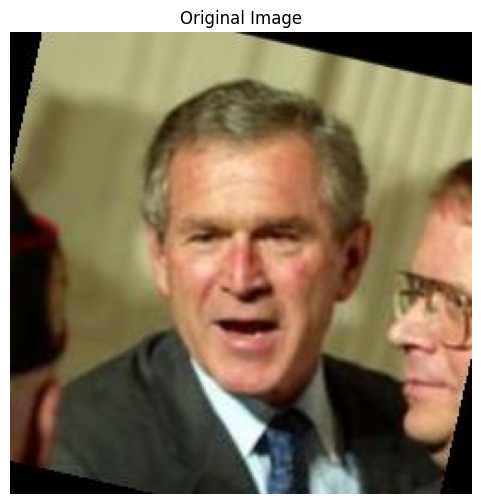

In [ ]:
# Number of epochs
num_epochs = 100

for epoch in range(num_epochs):
    total_loss = 0

    # Set the model to training mode
    vae.train()

    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)

        # Forward pass
        recon_batch, mu, logvar = vae(data)

        # Compute loss
        loss = loss_function(recon_batch, data, mu, logvar)

        # Enable anomaly detection for debugging
        with detect_anomaly():
            # Backward pass
            loss.backward()

        # Optimize
        optim.step()

        # Reset gradients
        optim.zero_grad()

        total_loss += loss.item()

    # Average loss for this epoch
    epoch_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")


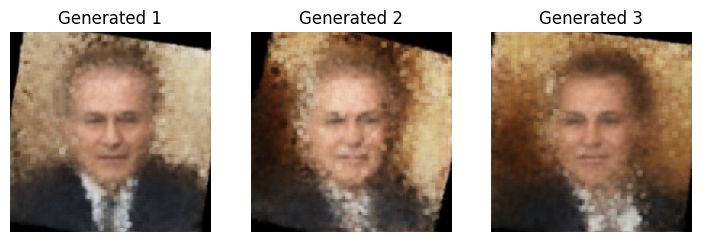

In [ ]:
# Function to generate and display varied images
def generate_and_display_varied_images(model, original_image, num_images=10, variation_factor=0.5):
    with torch.no_grad():
        # Encode the original image
        mu, logvar = model.encoder(original_image)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        # Generate and display varied images
        plt.figure(figsize=(15, 6))

        # Plot the original image
        plt.subplot(2, 5, 1)
        plt.imshow(original_image.cpu().squeeze().permute(1, 2, 0))
        plt.title("Original Image")
        plt.axis('off')

        # Generate and plot varied images
        for i in range(1, min(num_images, 10) + 1):
            # Introduce amplified variation
            z_varied = z + torch.randn_like(z) * variation_factor

            # Decode the varied latent vector
            generated_image_varied = model.decoder(z_varied)

            # Plotting
            plt.subplot(2, 5, i + 1)
            plt.imshow(generated_image_varied.cpu().squeeze().permute(1, 2, 0))
            plt.title(f"Generated {i}")
            plt.axis('off')

        plt.show()

# Example usage
generate_and_display_varied_images(vae, original_image, num_images=3, variation_factor=0.5)
